In [1]:
import torch
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import joblib
import sys
import numpy as np
import json
import time
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, precision_score, roc_auc_score,
    top_k_accuracy_score
)


MAX_EPOCHS = 25000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


In [2]:
# Load JSON file
with open('ensemble_results.json', 'r') as file:
    data = json.load(file)

# Function to process each entry
def process_entry(entry):
    metrics = {
        "accuracy": entry["accuracy"],
        "recall": entry["recall"],
        "f1_score": entry["f1_score"],
        "precision": entry["precision"],
        "roc_auc": entry["roc_auc"],
        "top5_accuracy": entry["top5_accuracy"],
        "inference_time": entry["inference_time"]
    }

    weights = entry["selected_weights"]
    activations = entry["activation_bits"]

    weight_index = 0
    updated_weights = []

    for bit in activations:
        if bit > 0.5 and weight_index < len(weights):
            updated_weights.append(weights[weight_index])
            weight_index += 1
        else:
            updated_weights.append(0.0)

    return {
        "metrics": metrics,
        "updated_weights": updated_weights
    }

# Dictionary to hold results for each key
results = {}

# Loop through all keys in the file
for key, entry in data.items():
    results[key] = process_entry(entry)

# Example: print everything nicely
for key, info in results.items():
    print(f"\n--- {key.upper()} ---")
    print("Metrics:")
    for m_key, m_val in info["metrics"].items():
        print(f"  {m_key}: {m_val}")
    print("Updated Weights:")
    print(info["updated_weights"])





--- ACC ---
Metrics:
  accuracy: 0.6493702770780856
  recall: 0.6493702770780856
  f1_score: 0.6189334693848085
  precision: 0.6173809469340443
  roc_auc: 0.9416404505495262
  top5_accuracy: 0.8997481108312343
  inference_time: 9.356147527694702
Updated Weights:
[0.07719512283802032, 0.16135337948799133, 0.06362076848745346, 0.16351158916950226, 0.17402200400829315, 0.0, 0.0, 0.0, 0.08711770921945572, 0.13290242850780487, 0.14027704298496246]

--- RECALL ---
Metrics:
  accuracy: 0.6337531486146095
  recall: 0.6337531486146095
  f1_score: 0.6142130942594919
  precision: 0.6203917490051634
  roc_auc: 0.9405445894466619
  top5_accuracy: 0.9032745591939546
  inference_time: 8.8707594871521
Updated Weights:
[0.303228497505188, 0.13721773028373718, 0.09513887763023376, 0.23675239086151123, 0.0, 0.08771230280399323, 0.0, 0.03424537926912308, 0.10570481419563293, 0.0, 0.0]

--- F1 ---
Metrics:
  accuracy: 0.6463476070528967
  recall: 0.6463476070528967
  f1_score: 0.6223835033139069
  precisi

In [3]:
metrics = []

metric_keys = [
    "accuracy", "recall", "f1_score",
    "precision", "roc_auc", "top5_accuracy",
    "inference_time"
]

# Go through each key and extract just the metric values
for entry in data.values():
    for key in metric_keys:
        metrics.append(entry[key])

print(metrics)


[0.6493702770780856, 0.6493702770780856, 0.6189334693848085, 0.6173809469340443, 0.9416404505495262, 0.8997481108312343, 9.356147527694702, 0.6337531486146095, 0.6337531486146095, 0.6142130942594919, 0.6203917490051634, 0.9405445894466619, 0.9032745591939546, 8.8707594871521, 0.6463476070528967, 0.6463476070528967, 0.6223835033139069, 0.616577005825025, 0.9401041911798013, 0.9007556675062972, 3.3466830253601074, 0.6418136020151134, 0.6418136020151134, 0.6168829099108196, 0.6205134816104734, 0.9378252997330851, 0.9042821158690176, 8.779212713241577, 0.5622166246851386, 0.5622166246851386, 0.5641753237466651, 0.5998869952655739, 0.93533977324051, 0.9133501259445844, 3.2631583213806152, 0.5118387909319899, 0.5118387909319899, 0.4773661410895331, 0.47109952159362783, 0.9290893661009583, 0.890176322418136, 5.258897304534912, 0.46700251889168765, 0.46700251889168765, 0.4384078701932947, 0.43136658709544345, 0.7925719522263934, 0.745088161209068, 0.049428701400756836]


In [4]:
keys = ["acc", "recall", "f1", "precision", "auc", "top5", "time"]

def generate_one_hot_and_metrics(results_dict):
    
    num_classes = len(results_dict) 
    # Create one-hot input
    index = np.random.randint(0, num_classes)
    one_hot = np.zeros(num_classes)
    one_hot[index] = 1
    key = keys[index]
    # Retrieve the metrics corresponding to the index
    selected_key = results_dict[key]
    
    selected_weights = selected_key["updated_weights"]

    # Create tensor versions
    input_tensor = torch.tensor(one_hot, dtype=torch.float32).to(DEVICE)
    target_tensor = torch.tensor([selected_weights], dtype=torch.float32).to(DEVICE)

    return input_tensor, target_tensor

In [5]:
input_vec, target_metrics = generate_one_hot_and_metrics(results)

print("Generated Input:", input_vec)
print("Target Metrics:", target_metrics)

Generated Input: tensor([0., 0., 0., 0., 0., 0., 1.], device='cuda:0')
Target Metrics: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')


In [6]:
from ensembler import FinalWeightGeneratorNN

model = FinalWeightGeneratorNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
from tqdm import tqdm

losses = []

for epoch in tqdm(range(MAX_EPOCHS), desc="Training"):
    # Generate input and target
    input_tensor, target_tensor = generate_one_hot_and_metrics(results)

    # Append all metrics to the one-hot input
    metrics_tensor = torch.tensor(metrics, dtype=torch.float32).to(DEVICE)
    input_tensor = torch.cat((input_tensor, metrics_tensor), dim=0)

    # Train step (assuming model.train_step returns a scalar loss)
    loss = model.train_step(input_tensor, target_tensor, optimizer)

    # Save loss
    losses.append(loss)  
    

torch.save(model.state_dict(), "final_weight_generator.pth")
    



Training: 100%|██████████| 25000/25000 [00:52<00:00, 480.68it/s]


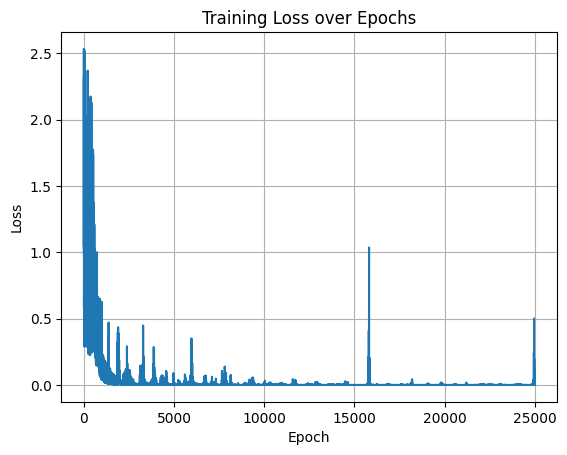

In [8]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()
